# i3sense Import and process data for small samples of water uptake

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import logging
import scipy.stats as stats

In [ ]:
#!pip install openpyxl

In [ ]:
 %cd {"/home/jupyter-bara/01_i3sense"}

## Load data
excel with two lists referencni and mereni_uzavrene
first row is reference values - beggining at time 15:07 - before some oscilations

In [2]:
df = pd.read_excel("small_uzavrene.xlsx", sheet_name = None)

# check sheet names
for sheet_name, names in df.items():
    print(f"Sheet name: {sheet_name}")
    print(names.head())  # or print(df) if you want the full table
    print("-" * 40)

Sheet name: referencni
                  cas  temp (°C)   RH (%)   m1 (g)   m2 (g)   m3 (g)   m4 (g)  \
0 2024-10-27 19:09:32    22.1982  49.6412  50.4833  56.1041  76.1091  61.5808   
1 2024-10-27 19:10:32    21.9837  49.5496  50.4819  56.1091  76.1059  61.5819   
2 2024-10-27 19:11:33    21.9086  49.4504  50.4828  56.1088  76.1116  61.5821   
3 2024-10-27 19:12:33    21.9622  49.4886  50.4849  56.1165  76.1125  61.5823   
4 2024-10-27 19:13:33    21.8979  49.8777  50.4846  56.1106  76.1186  61.5821   

    m5 (g)  
0  62.8388  
1  62.8401  
2  62.8429  
3  62.8450  
4  62.8474  
----------------------------------------
Sheet name: mereni_uzavrene
                  cas  temp (°C)   RH (%)   m1 (g)   m2 (g)   m3 (g)   m4 (g)  \
0 2024-10-29 15:07:38    24.6542  48.4128  50.3823  71.0868  60.1425  59.4147   
1 2024-10-29 15:08:38    24.6328  48.9393  50.3817  71.1526  60.1697  59.4641   
2 2024-10-29 15:09:38    24.5363  49.3131  50.3835  71.2151  60.1814  59.4774   
3 2024-10-29 15:10:

## Load comsol data

In [3]:
df_cm = pd.read_csv(
    'small_1000_IC09.txt',
    comment='%',
    delim_whitespace=True,
    names=['Time_s', 'w_2', 'w_3','w_4','w_5'],
    skiprows=5  # skip header rows manually if needed
)
df_cm

/var/folders/y_/s7jxg14916nc9xn1wcttf3cw0000gn/T/ipykernel_12426/568933787.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_cm = pd.read_csv(


,Time_s,w_2,w_3,w_4,w_5
0,0,0.376992,0.378711,0.378853,0.380191
1,600,0.377200,0.379007,0.379158,0.380599
2,1200,0.377410,0.379285,0.379444,0.380982
3,1800,0.377620,0.379552,0.379717,0.381337
4,2400,0.377802,0.379804,0.379976,0.381657
...,...,...,...,...,...
3890,2334000,0.454166,0.471156,0.472670,0.487252
3891,2334600,0.454177,0.471169,0.472683,0.487267
3892,2335200,0.454187,0.471182,0.472696,0.487282
3893,2335800,0.454198,0.471195,0.472709,0.487297


## Extract list of measured values and plotting

In [48]:
df_cm_o = pd.read_csv(
    'small_1000_IC09_otevrene.txt',
    comment='%',
    delim_whitespace=True,
    names=['Time_s', 'w_2', 'w_3','w_4','w_5'],
    skiprows=5  # skip header rows manually if needed
)
df_cm_o

/var/folders/y_/s7jxg14916nc9xn1wcttf3cw0000gn/T/ipykernel_12426/4180912139.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_cm_o = pd.read_csv(


,Time_s,w_2,w_3,w_4,w_5
0,0,0.376992,0.378711,0.378853,0.380191
1,600,0.377188,0.378994,0.379145,0.380587
2,1200,0.377385,0.379261,0.379420,0.380958
3,1800,0.377583,0.379516,0.379681,0.381300
4,2400,0.377754,0.379756,0.379927,0.381609
...,...,...,...,...,...
3890,2334000,0.419311,0.434669,0.435919,0.448757
3891,2334600,0.419314,0.434673,0.435924,0.448763
3892,2335200,0.419318,0.434678,0.435929,0.448769
3893,2335800,0.419321,0.434682,0.435933,0.448775


,cas,temp (°C),RH (%),m1 (g),m2 (g),m3 (g),m4 (g),m5 (g)
0,2024-10-27 19:09:32,22.1982,49.6412,50.4833,56.1041,76.1091,61.5808,62.8388
1,2024-10-27 19:10:32,21.9837,49.5496,50.4819,56.1091,76.1059,61.5819,62.8401
2,2024-10-27 19:11:33,21.9086,49.4504,50.4828,56.1088,76.1116,61.5821,62.8429
3,2024-10-27 19:12:33,21.9622,49.4886,50.4849,56.1165,76.1125,61.5823,62.8450
4,2024-10-27 19:13:33,21.8979,49.8777,50.4846,56.1106,76.1186,61.5821,62.8474
...,...,...,...,...,...,...,...,...
2550,2024-10-29 13:42:07,24.6221,46.1545,50.4049,56.3850,74.9177,61.4171,62.7754
2551,2024-10-29 13:43:07,24.6328,45.9562,50.4070,56.3764,74.9210,61.4181,62.7757
2552,2024-10-29 13:44:07,24.4290,46.4445,50.4052,56.3723,74.9326,61.4173,62.7755
2553,2024-10-29 13:45:07,24.4397,46.1088,50.4032,56.3675,74.9338,61.4159,62.7715


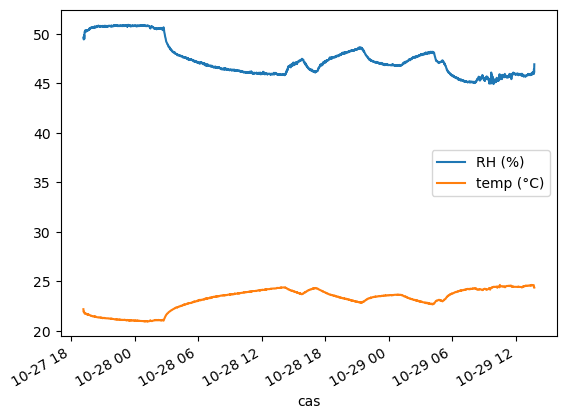

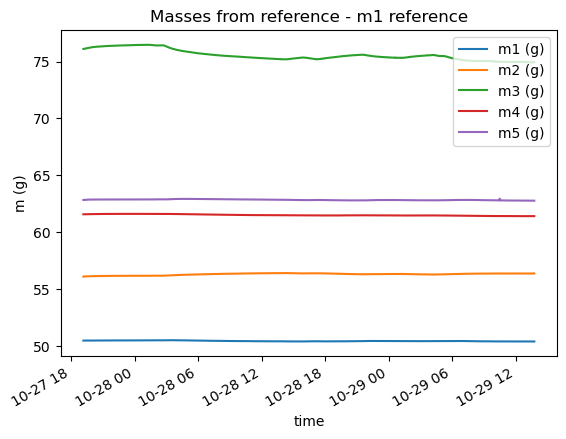

In [4]:
# from 1sheet - reference values calculate densities
ref = df["referencni"]

ref.plot (x='cas',y=['RH (%)','temp (°C)'])

ref.drop(["temp (°C)","RH (%)"], axis=1).plot(x="cas", subplots=False)
plt.title ('Masses from reference - m1 reference')
plt.xlabel ('time')
plt.ylabel ('m (g)')

display (ref)

,cas,temp (°C),RH (%),m1 (g),m2 (g),m3 (g),m4 (g),m5 (g)
0,2024-10-29 15:07:38,24.6542,48.4128,50.3823,71.0868,60.1425,59.4147,53.1139
1,2024-10-29 15:08:38,24.6328,48.9393,50.3817,71.1526,60.1697,59.4641,53.1493
2,2024-10-29 15:09:38,24.5363,49.3131,50.3835,71.2151,60.1814,59.4774,53.1495
3,2024-10-29 15:10:38,24.4183,49.9158,50.3879,71.2296,60.1730,59.4746,53.1530
4,2024-10-29 15:11:38,24.4826,48.4510,50.3843,71.2924,60.2073,59.5097,53.1796
...,...,...,...,...,...,...,...,...
38664,2024-11-25 16:03:35,25.3299,38.3878,50.1968,96.4731,64.7999,65.4245,66.1321
38665,2024-11-25 16:04:35,25.3299,35.1377,50.1973,96.4849,64.7940,65.4297,66.1321
38666,2024-11-25 16:05:35,25.3192,38.8151,50.1974,96.4771,64.7987,65.4245,66.1231
38667,2024-11-25 16:06:35,25.3085,36.9306,50.1984,96.4800,64.7887,65.4239,66.1183


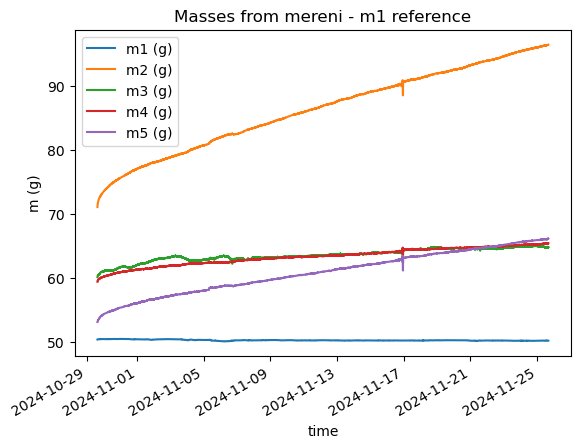

In [5]:
m = df["mereni_uzavrene"]

# plot data of mass - absolute values
m.drop(["temp (°C)","RH (%)"], axis=1).plot(x="cas", subplots=False)
plt.title ('Masses from mereni - m1 reference')
plt.xlabel ('time')
plt.ylabel ('m (g)')

m

37.33622372960252

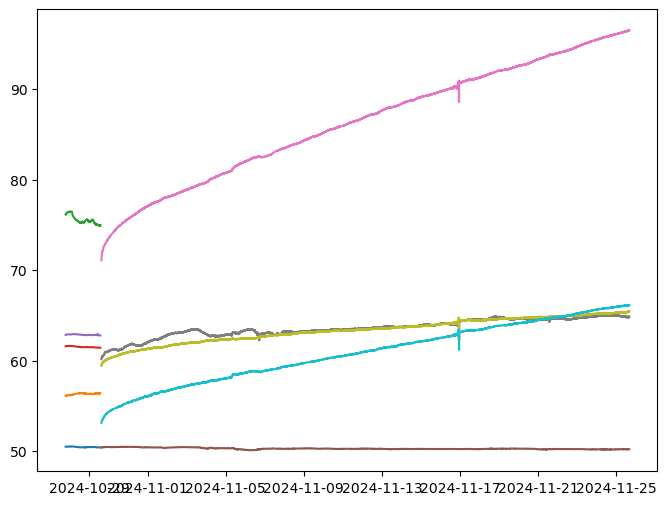

In [6]:
plt.figure(figsize=(8,6))
plt.plot (ref ["cas"], ref.drop(['cas','temp (°C)',"RH (%)"],axis = 1), label = "ref")
plt.plot (m ["cas"], m.drop(['cas','temp (°C)',"RH (%)"],axis = 1), label = "ref")

avg = m['RH (%)'].mean ()
avg

In [ ]:
m_pok = (m.iloc [1,3:] - m.iloc [0,3:])/m.iloc [0,3:]
m_pok

In [ ]:
#df['List1'].drop(["t","r"], axis=1).plot(x="cas", subplots=True)

## Mass, water mass increment, and moisture

In [30]:
# Prepare table
# Columns to keep unchanged
unchanged_cols = ["temp (°C)", "RH (%)"]

# Separate datetime column
datetime_col = "cas"
# Numeric columns (excluding unchanged)
numeric_cols = m.select_dtypes(include='number').columns.difference(unchanged_cols)
# Create a copy to store results
m_delta = m.copy()

# Mass incremenent calculation
# Subtract numeric columns
m_delta[numeric_cols] = m[numeric_cols] - m.iloc[0][numeric_cols]
# Subtract datetime separately
m_delta[datetime_col] = m[datetime_col] - m.iloc[0][datetime_col]
## Date to minutes and seconds
m_delta ["Time (min)"] = m_delta["cas"].dt.total_seconds() / 60
m_delta ["Time (s)"] = m_delta["cas"].dt.total_seconds()

#  Water Mass incerement calculation
# relative value of reference sample
m_delta["m1_rel"] = m["m1 (g)"]/m["m1 (g)"].iloc[0] 

for i in range(2, 6):  # for samples 2 to 5
    mass_col = f"m{i} (g)"
    water_col = f"water_mass {i} (g)"
    m_delta[water_col] = m_delta["m1_rel"] * m_delta[mass_col]

# Moisture calculation form reference list 
for i in range(1, 6):  # for m2 to m6
    m_col = f"m{i} (g)"
    w_col_ref = f"wref{i} (-)"
    m_delta[w_col_ref] = (m[m_col] - ref[m_col].iloc[-1]) / ref[m_col].iloc[-1]

# Moisture calculation form first row
for i in range(2, 6):  # for m2 to m6
    m_col = f"m{i} (g)"
    w_col = f"w {i} (-)"
    m_delta[w_col] = (m[m_col] - m[m_col].iloc[0]) / m[m_col].iloc[0]
    

# plot table
m_delta

,cas,temp (°C),RH (%),m1 (g),m2 (g),m3 (g),m4 (g),m5 (g),Time (min),Time (s),...,water_mass 5 (g),wref1 (-),wref2 (-),wref3 (-),wref4 (-),wref5 (-),w 2 (-),w 3 (-),w 4 (-),w 5 (-)
0,0 days 00:00:00,24.6542,48.4128,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,-0.000429,0.260943,-0.197475,-0.032640,-0.153919,0.000000,0.000000,0.000000,0.000000
1,0 days 00:01:00,24.6328,48.9393,-0.0006,0.0658,0.0272,0.0494,0.0354,1.00,60.0,...,0.0354,-0.000440,0.262110,-0.197112,-0.031835,-0.153355,0.000926,0.000452,0.000831,0.000666
2,0 days 00:02:00,24.5363,49.3131,0.0012,0.1283,0.0389,0.0627,0.0356,2.00,120.0,...,0.035601,-0.000405,0.263219,-0.196956,-0.031619,-0.153352,0.001805,0.000647,0.001055,0.000670
3,0 days 00:03:00,24.4183,49.9158,0.0056,0.1428,0.0305,0.0599,0.0391,3.00,180.0,...,0.039104,-0.000317,0.263476,-0.197068,-0.031664,-0.153296,0.002009,0.000507,0.001008,0.000736
4,0 days 00:04:00,24.4826,48.4510,0.002,0.2056,0.0648,0.095,0.0657,4.00,240.0,...,0.065703,-0.000389,0.264590,-0.196610,-0.031093,-0.152873,0.002892,0.001077,0.001599,0.001237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38664,27 days 00:55:57,25.3299,38.3878,-0.1855,25.3863,4.6574,6.0098,13.0182,38935.95,2336157.0,...,12.970269,-0.004109,0.711247,-0.135328,0.065209,0.053455,0.357117,0.077439,0.101150,0.245100
38665,27 days 00:56:57,25.3299,35.1377,-0.185,25.3981,4.6515,6.015,13.0182,38936.95,2336217.0,...,12.970398,-0.004099,0.711456,-0.135407,0.065294,0.053455,0.357283,0.077341,0.101238,0.245100
38666,27 days 00:57:57,25.3192,38.8151,-0.1849,25.3903,4.6562,6.0098,13.0092,38937.95,2336277.0,...,12.961457,-0.004097,0.711318,-0.135344,0.065209,0.053311,0.357173,0.077419,0.101150,0.244930
38667,27 days 00:58:57,25.3085,36.9306,-0.1839,25.3932,4.6462,6.0092,13.0044,38938.95,2336337.0,...,12.956933,-0.004077,0.711370,-0.135477,0.065199,0.053235,0.357214,0.077253,0.101140,0.244840


In [59]:
#m_delta.plot(x="cas", y=["w2 (-)"])
colors = plt.cm.Set2.colors
colors

((0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254))

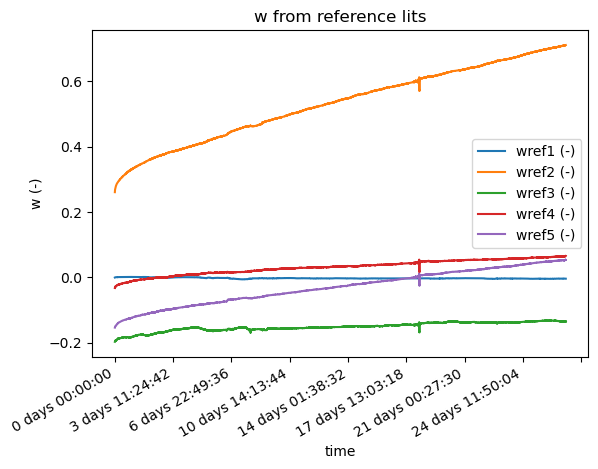

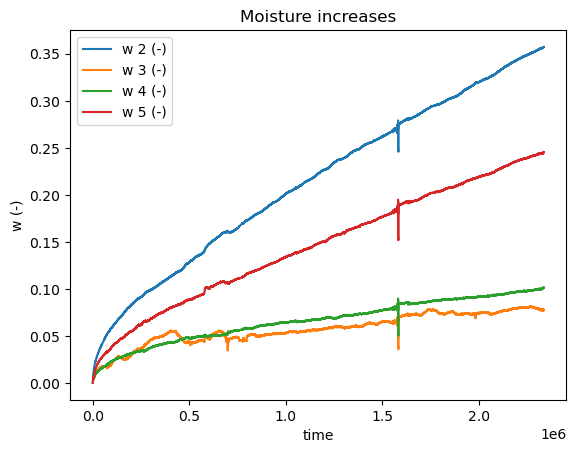

In [61]:
## plot data moisture
# Dynamically find all 'water_mass' columns
w_cols = [col for col in m_delta.columns if col.startswith("wref") and " (-)" in col]

# Now plot them
m_delta.plot(x="cas", y=w_cols)

# Add labels and title
plt.title("w from reference lits")
plt.xlabel('time')
plt.ylabel('w (-)')
plt.show()

## plot data Masses
# Dynamically find all 'water_mass' columns
w_cols = [col for col in m_delta.columns if col.startswith("w ") and " (-)" in col]

# Now plot them
m_delta.plot(x= "Time (s)", y=w_cols)
color=['0.4']

# Add labels and title
plt.title("Moisture increases")
plt.xlabel('time')
plt.ylabel('w (-)')
plt.show()

In [9]:
## from comsol moisture
# Moisture calculation form first row
for i in range(2, 6):  # for m2 to m6
    w_col = f"w_{i}"
    w_col_r = f"w {i} (-)"
    df_cm[w_col_r] = (df_cm[w_col] - df_cm[w_col].iloc[0])

df_cm


,Time_s,w_2,w_3,w_4,w_5,w 2 (-),w 3 (-),w 4 (-),w 5 (-)
0,0,0.376992,0.378711,0.378853,0.380191,0.000000,0.000000,0.000000,0.000000
1,600,0.377200,0.379007,0.379158,0.380599,0.000208,0.000296,0.000305,0.000408
2,1200,0.377410,0.379285,0.379444,0.380982,0.000418,0.000574,0.000591,0.000791
3,1800,0.377620,0.379552,0.379717,0.381337,0.000628,0.000841,0.000864,0.001146
4,2400,0.377802,0.379804,0.379976,0.381657,0.000811,0.001094,0.001123,0.001466
...,...,...,...,...,...,...,...,...,...
3890,2334000,0.454166,0.471156,0.472670,0.487252,0.077174,0.092445,0.093817,0.107061
3891,2334600,0.454177,0.471169,0.472683,0.487267,0.077185,0.092458,0.093830,0.107076
3892,2335200,0.454187,0.471182,0.472696,0.487282,0.077196,0.092471,0.093844,0.107091
3893,2335800,0.454198,0.471195,0.472709,0.487297,0.077207,0.092484,0.093857,0.107106


In [46]:
df_cm.to_csv ('df_cm_zaloha.csv')

In [49]:
## from comsol moisture
# Moisture calculation form first row
for i in range(2, 6):  # for m2 to m6
    w_col = f"w_{i}"
    w_col_r = f"w {i} (-)"
    df_cm_o[w_col_r] = (df_cm_o[w_col] - df_cm_o[w_col].iloc[0])

df_cm_o

,Time_s,w_2,w_3,w_4,w_5,w 2 (-),w 3 (-),w 4 (-),w 5 (-)
0,0,0.376992,0.378711,0.378853,0.380191,0.000000,0.000000,0.000000,0.000000
1,600,0.377188,0.378994,0.379145,0.380587,0.000196,0.000284,0.000293,0.000396
2,1200,0.377385,0.379261,0.379420,0.380958,0.000394,0.000550,0.000567,0.000767
3,1800,0.377583,0.379516,0.379681,0.381300,0.000592,0.000805,0.000828,0.001110
4,2400,0.377754,0.379756,0.379927,0.381609,0.000762,0.001045,0.001075,0.001418
...,...,...,...,...,...,...,...,...,...
3890,2334000,0.419311,0.434669,0.435919,0.448757,0.042320,0.055958,0.057067,0.068566
3891,2334600,0.419314,0.434673,0.435924,0.448763,0.042323,0.055963,0.057071,0.068572
3892,2335200,0.419318,0.434678,0.435929,0.448769,0.042326,0.055967,0.057076,0.068578
3893,2335800,0.419321,0.434682,0.435933,0.448775,0.042330,0.055972,0.057081,0.068584


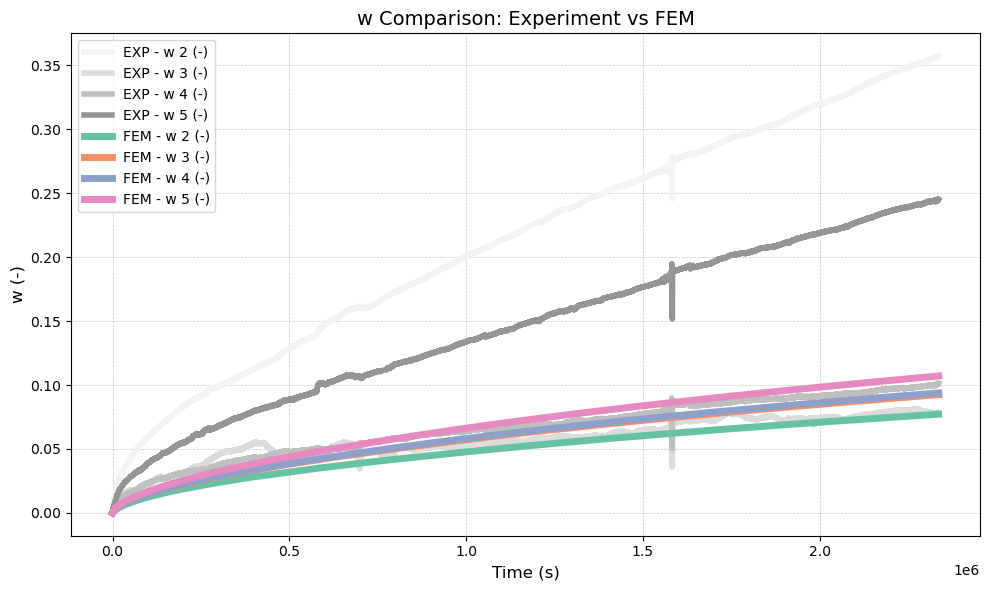

In [45]:
# Make sure your w_cols and w_com_cols are aligned (same order of variables)
num_lines = len(w_cols)

# Grey shades for m_delta (light to dark)
greys = cm.Greys(np.linspace(0.1, 0.5, num_lines))  # adjust range as needed

# Mint-style palette (or use 'Set2' or a custom pastel palette)
colors = plt.cm.Set2.colors  # Set2 is nice and minty

plt.figure(figsize=(10,6))

# First group: m_delta (thick grey lines)
for i, col in enumerate(w_cols):
    plt.plot(
        m_delta["Time (s)"], m_delta[col],
        color=greys[i % len(greys)],
        linewidth=4,
        linestyle='-',
        label=f"EXP - {col}"
    )

# Second group: df_cm (thin colored lines)
for i, col in enumerate(w_com_cols):
    plt.plot(
        df_cm["Time_s"], df_cm[col],
        color=colors[i % len(colors)],
        linewidth=5,
        linestyle='-',
        label=f"FEM - {col}"
    )
    
# Aesthetics
plt.title("w Comparison: Experiment vs FEM", fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('w (-)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

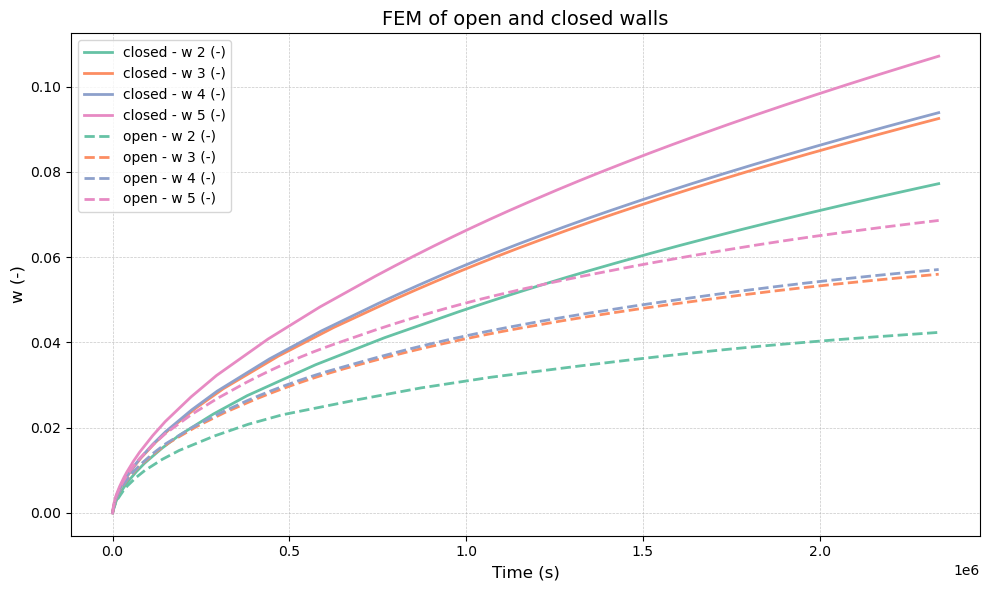

In [51]:
# Mint-style palette (Set2 works well, or use a custom one)
colors = plt.cm.Set2.colors

plt.figure(figsize=(10,6))

# First group: df_cm (solid lines)
for i, col in enumerate(w_com_cols):
    plt.plot(
        df_cm["Time_s"], df_cm[col],
        color=colors[i % len(colors)],
        linewidth=2,
        linestyle='-',  # solid line
        label=f"closed - {col}"
    )

# Second group: df_cm_o (dashed lines, same colors)
for i, col in enumerate(w_com_cols):
    plt.plot(
        df_cm_o["Time_s"], df_cm_o[col],
        color=colors[i % len(colors)],
        linewidth=2,
        linestyle='--',  # dashed line
        label=f"open - {col}"
    )

# Aesthetics
plt.title("FEM of open and closed walls", fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('w (-)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

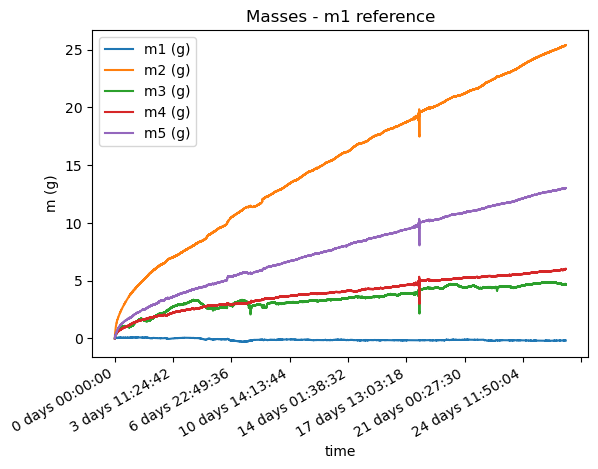

In [ ]:
## plot data Masses
# Dynamically find all 'water_mass' columns
masses_cols = [col for col in m_delta.columns if col.startswith("m") and " (g)" in col]

# Now plot them
m_delta.plot(x="cas", y=masses_cols)

# Add labels and title
plt.title('Masses - m1 reference')
plt.xlabel('time')
plt.ylabel('m (g)')
plt.show()

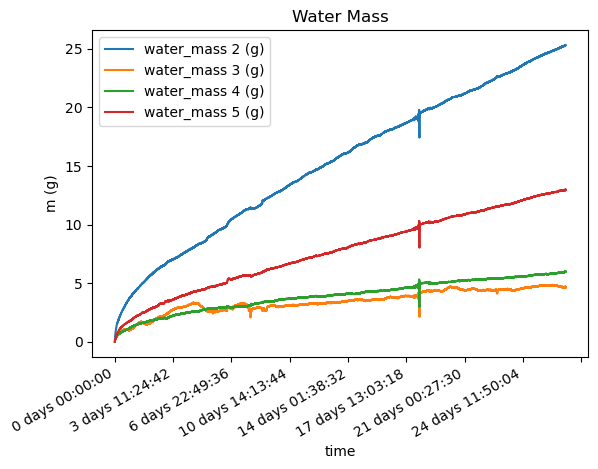

,cas,temp (°C),RH (%),m1 (g),m2 (g),m3 (g),m4 (g),m5 (g),Time (min),Time (s),...,wref1 (-),wref2 (-),wref3 (-),wref4 (-),wref5 (-),wrow1 (-),wrow2 (-),wrow3 (-),wrow4 (-),wrow5 (-)
0,0 days 00:00:00,24.6542,48.4128,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,-0.000429,0.260943,-0.197475,-0.032640,-0.153919,0.000000,0.000000,0.000000,0.000000,0.000000
1,0 days 00:01:00,24.6328,48.9393,-0.0006,0.0658,0.0272,0.0494,0.0354,1.00,60.0,...,-0.000440,0.262110,-0.197112,-0.031835,-0.153355,-0.000012,0.000926,0.000452,0.000831,0.000666
2,0 days 00:02:00,24.5363,49.3131,0.0012,0.1283,0.0389,0.0627,0.0356,2.00,120.0,...,-0.000405,0.263219,-0.196956,-0.031619,-0.153352,0.000024,0.001805,0.000647,0.001055,0.000670
3,0 days 00:03:00,24.4183,49.9158,0.0056,0.1428,0.0305,0.0599,0.0391,3.00,180.0,...,-0.000317,0.263476,-0.197068,-0.031664,-0.153296,0.000111,0.002009,0.000507,0.001008,0.000736
4,0 days 00:04:00,24.4826,48.4510,0.002,0.2056,0.0648,0.095,0.0657,4.00,240.0,...,-0.000389,0.264590,-0.196610,-0.031093,-0.152873,0.000040,0.002892,0.001077,0.001599,0.001237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38664,27 days 00:55:57,25.3299,38.3878,-0.1855,25.3863,4.6574,6.0098,13.0182,38935.95,2336157.0,...,-0.004109,0.711247,-0.135328,0.065209,0.053455,-0.003682,0.357117,0.077439,0.101150,0.245100
38665,27 days 00:56:57,25.3299,35.1377,-0.185,25.3981,4.6515,6.015,13.0182,38936.95,2336217.0,...,-0.004099,0.711456,-0.135407,0.065294,0.053455,-0.003672,0.357283,0.077341,0.101238,0.245100
38666,27 days 00:57:57,25.3192,38.8151,-0.1849,25.3903,4.6562,6.0098,13.0092,38937.95,2336277.0,...,-0.004097,0.711318,-0.135344,0.065209,0.053311,-0.003670,0.357173,0.077419,0.101150,0.244930
38667,27 days 00:58:57,25.3085,36.9306,-0.1839,25.3932,4.6462,6.0092,13.0044,38938.95,2336337.0,...,-0.004077,0.711370,-0.135477,0.065199,0.053235,-0.003650,0.357214,0.077253,0.101140,0.244840


In [22]:
## plot data Water Masse
# Dynamically find all 'water_mass' columns
water_cols = [col for col in m_delta.columns if col.startswith("water_mass")]

# Now plot them
m_delta.plot(x="cas", y=water_cols)

# Add labels and title
plt.title('Water Mass')
plt.xlabel('time')
plt.ylabel('m (g)')
plt.show()
m_delta

## RVD (EMC) for boundary conditions

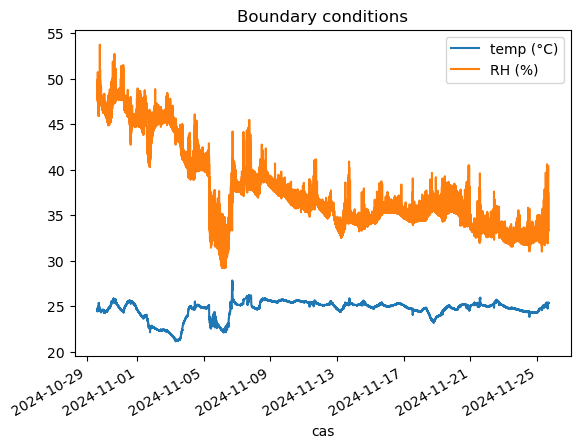

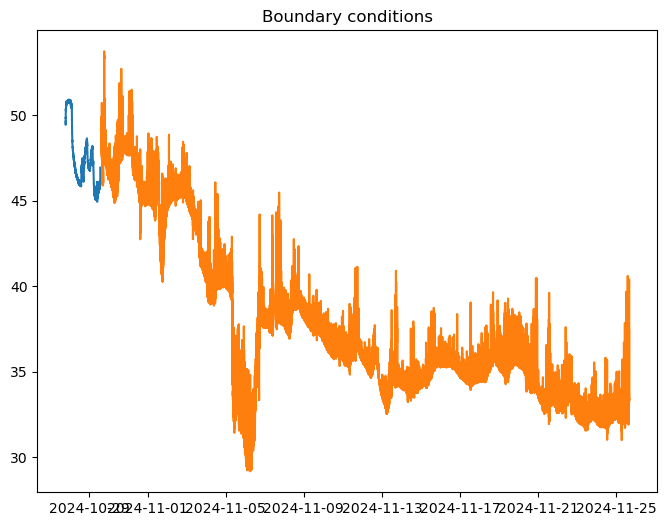

37.33622372960252

In [64]:
m.plot (x='cas',y=["temp (°C)","RH (%)"])

plt.title('Boundary conditions')
plt.show()

plt.figure(figsize=(8,6))
plt.plot (ref ["cas"],ref ["RH (%)"], label = "ref")
plt.plot(m ["cas"],m['RH (%)'], label='mer')

plt.title('Boundary conditions')
plt.show()

avg = m['RH (%)'].mean ()
avg

## Wood moisture based on Anderson - McCarty Sorption

In [52]:
# Value A eq. 4.38a, Horacek 1998 constants are given
A = 7.731706 - 0.014348 * (m_delta["temp (°C)"]+273.5)
A

0        3.453790
1        3.454097
2        3.455481
3        3.457174
4        3.456252
           ...   
38664    3.444095
38665    3.444095
38666    3.444248
38667    3.444402
38668    3.444248
Name: temp (°C), Length: 38669, dtype: float64

In [53]:
# Value B eq. 4.38a, Horacek 1998 constants are given
B = 0.008746 + 0.000567 * (m_delta["temp (°C)"]+273.5)
B

0        0.177799
1        0.177787
2        0.177733
3        0.177666
4        0.177702
           ...   
38664    0.178183
38665    0.178183
38666    0.178176
38667    0.178170
38668    0.178176
Name: temp (°C), Length: 38669, dtype: float64

In [54]:
# Moisture content by eq. 4.37b, Horacek 1998, the results in in %, therefore needs to be divided by 100
#
w = pd.DataFrame ()
w ["Time (s)"] = m_delta["cas"].dt.total_seconds()
w ["EMC_amb"] = (1/B)*np.log(A/(np.log(1/(m_delta["RH (%)"]/100))))/100
w

,Time (s),EMC_amb
0,0.0,0.087767
1,60.0,0.088623
2,120.0,0.089275
3,180.0,0.090312
4,240.0,0.087917
...,...,...
38664,2336157.0,0.071846
38665,2336217.0,0.066886
38666,2336277.0,0.072503
38667,2336337.0,0.069632


<Axes: xlabel='Time (s)'>

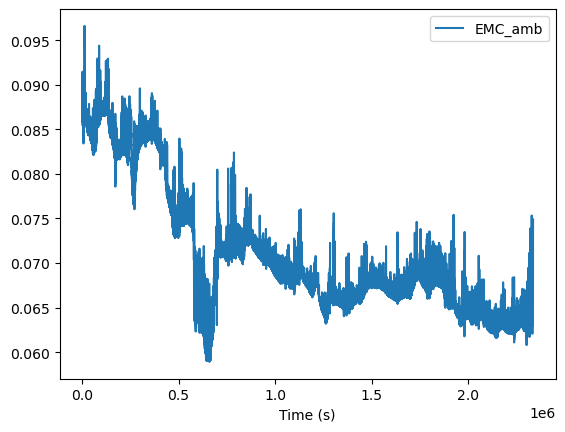

In [55]:
w.plot(x='Time (s)',y=["EMC_amb"])

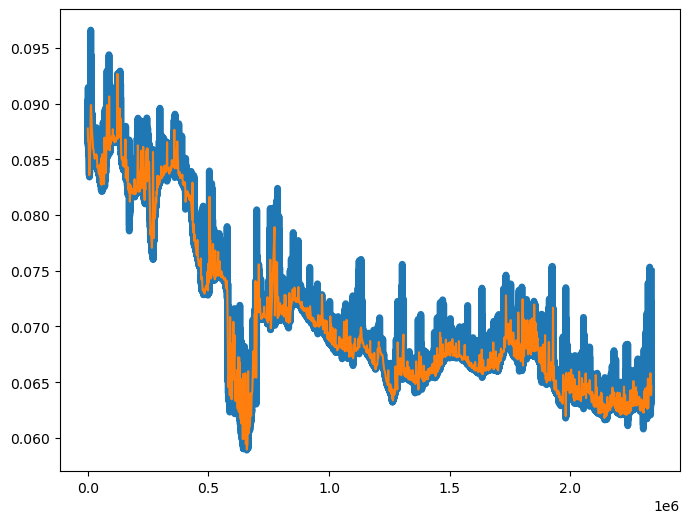

In [56]:
emc_opt = pd.read_csv("EMC_amb_smoothed_movmean_FIN.csv")
emc_opt["Time"] = emc_opt["x"] * 60
emc_opt

plt.figure(figsize=(8,6))
plt.plot (w ["Time (s)"],w ["EMC_amb"], label = "orig", linewidth = 5)
plt.plot(emc_opt ["Time"],emc_opt['ysmooth3'], label='opt')


EMC_smoot = pd.DataFrame({
    'Time': emc_opt['Time'],
    'EMC_amb': emc_opt['ysmooth3']
})

# Display the result
EMC_smoot

EMC_smoot.to_csv ('EMC_s.csv',index=False)

## SMOOTHED

In [57]:
# Smooth EMC_amb using moving average with window size N
w_s = pd.DataFrame ()
N = 1000  # You can change this — larger N = smoother
w_s ['Time (s)'] = w ['Time (s)']
w_s ['EMC_amb_SMA'] = w['EMC_amb'].rolling(window=N, center=True).mean()
w_s['EMC_amb_SMA'] = w_s['EMC_amb_SMA'].fillna(method='ffill').fillna(method='bfill')



/var/folders/y_/s7jxg14916nc9xn1wcttf3cw0000gn/T/ipykernel_12426/1313239130.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  w_s['EMC_amb_SMA'] = w_s['EMC_amb_SMA'].fillna(method='ffill').fillna(method='bfill')


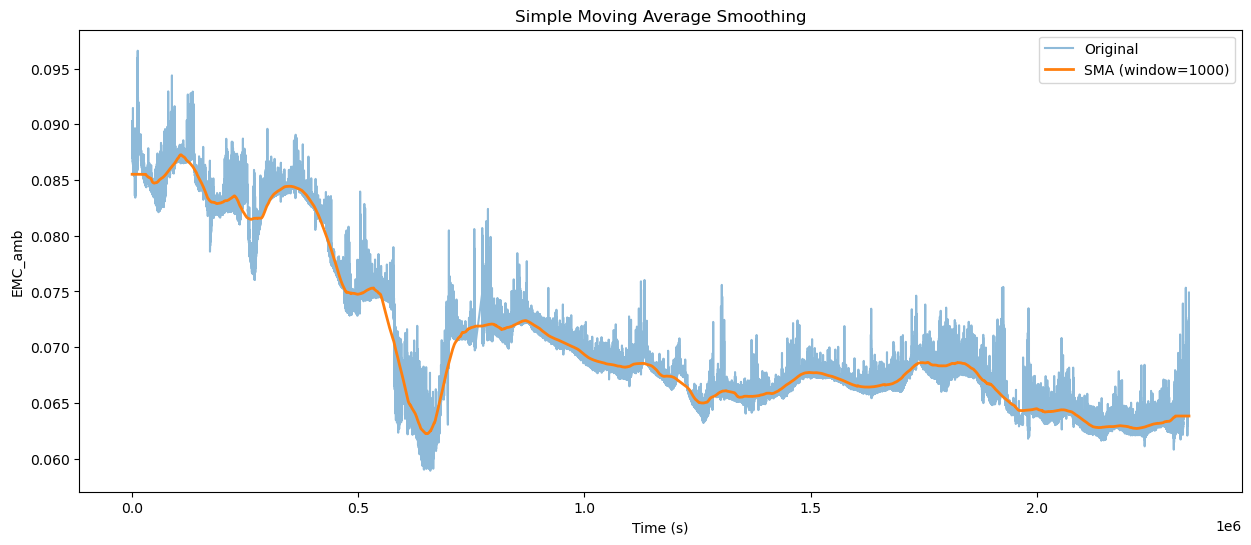

In [58]:
# Plot original vs smoothed
plt.figure(figsize=(15, 6))
plt.plot(w['Time (s)'], w['EMC_amb'], label='Original', alpha=0.5)
plt.plot(w['Time (s)'], w_s['EMC_amb_SMA'], label=f'SMA (window={N})', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('EMC_amb')
plt.legend()
plt.title('Simple Moving Average Smoothing')
plt.show()

In [ ]:
w_s.head(1000)  # first 1000 row

In [ ]:
w_s.to_csv ('EMC_s_bara.csv',index=False)

## Density for input
Density as function of moisture (EMC)

In [ ]:
#density of reference list
dens = pd.DataFrame()

for i in range(1, 6):  # for samples 2 to 5
    mass_col = f"m{i} (g)"
    dens[mass_col] = (ref[mass_col] / 1000) / (0.02 * 0.02 * 0.3)

# use the last density of m2 sample as reference for rho_0 - input in comsol
rho_refm2 = dens['m2 (g)'].iloc[-1]
rho_refm2

In [ ]:
# density of dry wood [kg/m3] based on literature values
rho_0 = 420 
rho_amb = rho_0*(1+w["EMC_amb"])/(1+0.993*rho_0*w["EMC_amb"])
rho_amb

## Density by the equation with k_av
$$
rho_w = rho_0 * \frac{(1+EMC)}{(1 + k_{av} * EMC)}
$$


In [ ]:
# for m2 sampe
k_av = 0.5
#rho_0m2 = rho_refm2/1.17105
# zkontrolovat zavorky
rho_0m2 = rho_refm2*(1+k_av*0.11)/(1+0.11)
rho_0m2

In [ ]:
rho_amb2 = pd.DataFrame ()
rho_amb2 ["Time (min)"] = w ["Time (min)"]
rho_amb2 ["rho_amb"] = rho_0m2*(1+w["EMC_amb"])/(1+k_av*w["EMC_amb"])
rho_amb2

In [ ]:
rho_amb2.to_csv("rho_amb.csv", index=False)

In [21]:
#dens_mer = pd.DataFrame()

#for i in range(1, 6):  # for samples 2 to 5
#    mass_col = f"m{i} (g)"
#    dens_mer[mass_col] = (m[mass_col].iloc[0] / 1000) / (0.02 * 0.02 * 0.3)

#dens_mer 

# use the last density of m2 sample as reference for rho_0 - input in comsol
#rho_refm2 = dens['m2 (g)'].iloc[-1]
# rho_refm2
k_av = 0.5
dens_mer = {}
rho_0_mer = {}

for i in range(1, 6):
    mass_col = f"m{i} (g)"
    dens_col = f"rho{i} (kg/m3)"
    dens_mer[dens_col] = (m[mass_col].iloc[0] / 1000) / (0.02 * 0.02 * 0.3)
    rho_0_mer[dens_col]  = dens_mer[dens_col]*(1+k_av*0.09)/(1+0.09)

dens_mer = pd.Series(dens_mer)
rho_0_mer = pd.Series (rho_0_mer)

print(dens_mer)

print (rho_0_mer)

rho1 (kg/m3)    419.852500
rho2 (kg/m3)    592.390000
rho3 (kg/m3)    501.187500
rho4 (kg/m3)    495.122500
rho5 (kg/m3)    442.615833
dtype: float64
rho1 (kg/m3)    402.519140
rho2 (kg/m3)    567.933532
rho3 (kg/m3)    480.496273
rho4 (kg/m3)    474.681663
rho5 (kg/m3)    424.342703
dtype: float64


## Compare results with comsol

In [ ]:
m_fin = pd.DataFrame ()
m_fin ["Time (min)"] = df_cm["Time_min"]
m_fin ["cb"] = df_cm ['c_b']
m_fin ["cw"] = df_cm ['c_w']
m_fin ["m_cw"] = df_cm["c_w"]*(rho_0m2*(0.02*0.02*0.3))/(1-(rho_0m2*(0.02*0.02*0.3)))
m_fin  ["w_cw"] = df_cm ['c_b'] + df_cm['c_b'] * (1/1.117)/420
m_fin

In [ ]:
plt.figure(figsize=(8,6))
plt.plot (m_fin ["Time (min)"],m_fin ["m_cw"], label = "fem")
plt.plot(m_delta ["Time (min)"],m_delta['m2 (g)'], label='exp')

# Labels and legend
plt.xlabel('Time (min)')
plt.ylabel('c_w')
plt.title('Comparison of c_w over time')
plt.legend()
plt.grid(True)
plt.show()

## BL funkce paja

In [20]:
# calculation of b_l function
c_win = 0.28*446
c_w = 128.12

print(c_win)

K_L = 1e-12

B_Lin = K_L * (-0.61 * (12400 * (c_win / 996.27)**(-0.61))) * (1 / c_w)
print(B_Lin)

B_L = K_L * (-0.61 * (12400 * (c_w / 996.27)**(-0.61))) * (1 / c_w)
print(B_L)

#B_L
#K_L
#(c_b<=0.28,10^-12,(K_L*(-0.61*(12400*(c_w/996.27)^(-0.61)))*(1/c_w)))

124.88000000000001
-2.0954819753051125e-10
-2.0629954263984132e-10


## SMOOTHING